# Flight Delay Prediction Project

## Part 2: Adding Weather data
Now that we have explored the entire dataset, we load it to new datafarme and then make a subset of top 50 busiest airports based on arrivals and departures. We later append the weather data for origin and destination airports obtained from [National Centers for Environmental Information](https://www.ncdc.noaa.gov) at the time of Departure (CSR_DEP_TIME) and landing (CSR_ARR_TIME)


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import time
from os import walk
os.chdir("/content/drive/MyDrive/Projects/Flight_Delay_Predict_Project") #Default Project directory

df = pd.read_csv('CodeFiles/Full_airline_data.csv')

## Make Subset for the top 50 airports and find the amount of data retained
We observed that 56.39% of all flights from the 4 months data originate and end in the top 50 airports.

In [ ]:
#Make subset of data containing only flights from top 50 airports
top50_airport = pd.read_csv('CodeFiles/top50airports.csv')['IATA'].tolist()
df_sub = df[df['ORIGIN'].isin(top50_airport)]
df_sub = df_sub[df_sub['DEST'].isin(top50_airport)]

In [ ]:
#Check the % of data retained:
data_retained = len(df_sub.index)/len(df.index)
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 56.39 %


## Finally Read, load and combine the weather dataset

In [ ]:
#Read the weather csv files
tic = time.time()
#Read all the airline data files
df_weather = pd.DataFrame()

f = []
for (dirpath,dirnames,filenames) in walk('weather/'):
    f.extend(filenames)
    break

for file in f:
    df_weather = df_weather.append(pd.read_csv('weather/'+file,low_memory=False))
    
toc = time.time()
print(toc-tic)

7.628483295440674


In [ ]:
#Select the weather parameters which affect flight status: Visibility, Temperature, Wind Speed, Precipitation
df_weather = df_weather[['STATION','DATE','HourlyVisibility','HourlyDryBulbTemperature','HourlyWindSpeed','HourlyPrecipitation']].copy()

In [ ]:
map_dict = {}
with open("data/dict.txt") as f:
  for line in f:
      (key, val) = line.split()
      map_dict[int(key)] = val

In [ ]:
#Replacing Long Format Station Names with IATA Airport codes
df_weather["STATION"] = df_weather["STATION"].map(map_dict)

In [ ]:
def tryconvert(x):
        try:
            if str(x)[-1].isalpha():
                return(float(str(x)[:-1]))
            else:
                return(float(str(x)))
        except:
            return(np.nan)

#Get the Year, Month, Date and Hour from df_weather
#Delete duplicate rows with data from the same station and same date/hour
#Delete "DATE"

df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])

df_weather['YEAR']= df_weather['DATE'].apply(lambda time: time.year)
df_weather['MONTH']= df_weather['DATE'].apply(lambda time: time.month)
df_weather['DAY_OF_MONTH']= df_weather['DATE'].apply(lambda time: time.day)
df_weather['HOUR']= df_weather['DATE'].apply(lambda time: time.hour)

df_weather.drop_duplicates(['STATION','YEAR','MONTH','DAY_OF_MONTH','HOUR'],inplace=True)
df_weather.drop('DATE',axis = 1,inplace=True)

df_weather['HourlyVisibility'] = df_weather['HourlyVisibility'].apply(lambda x: tryconvert(x))
df_weather['HourlyDryBulbTemperature'] = df_weather['HourlyDryBulbTemperature'].apply(lambda x: tryconvert(x))
df_weather['HourlyWindSpeed'] = df_weather['HourlyWindSpeed'].apply(lambda x: tryconvert(x))
df_weather['HourlyPrecipitation'] = df_weather['HourlyPrecipitation'].apply(lambda x: tryconvert(x))

#Replace NaNs with 0 in Hourly Precip
df_weather['HourlyPrecipitation'].fillna(value=0,inplace=True)
#Replace NaNs with average value for Hourly Visibility
df_weather['HourlyVisibility'].fillna(df_weather['HourlyVisibility'].mean(),inplace=True)


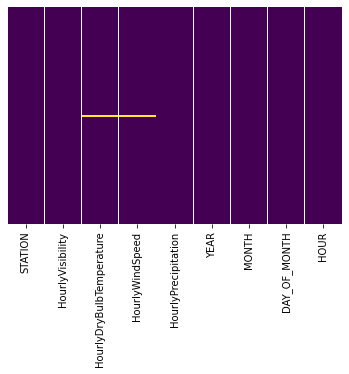

In [ ]:
#Check for any missing data:
#Missing data will show up as Yellow lines
sns.heatmap(df_weather.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Calculate Average Weather values for each station

In [ ]:
df_avg_DEP = df_weather.groupby('STATION').mean()
df_avg_DEP.drop(['YEAR','MONTH','DAY_OF_MONTH','HOUR'],axis = 1,inplace=True)
df_avg_DEP.reset_index(drop=False,inplace=True)
df_avg_DEP.rename(index=str, columns={"STATION": "ORIGIN"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HourlyVisibility": "DEP_AVG_HourlyVisibility"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HourlyDryBulbTemperature": "DEP_AVG_HourlyDryBulbTemperature"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HourlyWindSpeed": "DEP_AVG_HourlyWindSpeed"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HourlyPrecipitation": "DEP_AVG_HourlyPrecipitation"},inplace=True)

df_avg_ARR = df_weather.groupby('STATION').mean()
df_avg_ARR.drop(['YEAR','MONTH','DAY_OF_MONTH','HOUR'],axis = 1,inplace=True)
df_avg_ARR.reset_index(drop=False,inplace=True)
df_avg_ARR.rename(index=str, columns={"STATION": "DEST"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HourlyVisibility": "ARR_AVG_HourlyVisibility"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HourlyDryBulbTemperature": "ARR_AVG_HourlyDryBulbTemperature"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HourlyWindSpeed": "ARR_AVG_HourlyWindSpeed"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HourlyPrecipitation": "ARR_AVG_HourlyPrecipitation"},inplace=True)


In [ ]:
#Create two copies of the Weather Dataframe, so that we can two Joins, one for Origin, and one for Destination
df_weather_origin = df_weather.copy()
df_weather_dest = df_weather.copy()
del df_weather

#Rename the Columns, add DEP_ to each column name and STATION to ORIGIN
df_weather_origin.rename(index=str, columns={"STATION": "ORIGIN"},inplace=True)
df_weather_origin.rename(index=str, columns={"HourlyVisibility": "DEP_HourlyVisibility"},inplace=True)
df_weather_origin.rename(index=str, columns={"HourlyDryBulbTemperature": "DEP_HourlyDryBulbTemperature"},inplace=True)
df_weather_origin.rename(index=str, columns={"HourlyWindSpeed": "DEP_HourlyWindSpeed"},inplace=True)
df_weather_origin.rename(index=str, columns={"HourlyPrecipitation": "DEP_HourlyPrecipitation"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOUR": "DEP_HOUR"},inplace=True)

#Rename the Columns, add ARR_ to each column name and STATION to DEST
df_weather_dest.rename(index=str, columns={"STATION": "DEST"},inplace=True)
df_weather_dest.rename(index=str, columns={"HourlyVisibility": "ARR_HourlyVisibility"},inplace=True)
df_weather_dest.rename(index=str, columns={"HourlyDryBulbTemperature": "ARR_HourlyDryBulbTemperature"},inplace=True)
df_weather_dest.rename(index=str, columns={"HourlyWindSpeed": "ARR_HourlyWindSpeed"},inplace=True)
df_weather_dest.rename(index=str, columns={"HourlyPrecipitation": "ARR_HourlyPrecipitation"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOUR": "ARR_HOUR"},inplace=True)


In [ ]:
#Merge the Actual Weather during Take-off and Landing for each flight 
df_sub = pd.merge(df_sub, df_weather_origin, on=['ORIGIN','YEAR','MONTH','DAY_OF_MONTH','DEP_HOUR'], how='left')
df_sub = pd.merge(df_sub, df_weather_dest, on=['DEST','YEAR','MONTH','DAY_OF_MONTH','ARR_HOUR'], how='left')

In [ ]:
#Merge the Average weather for Origin and Destination Airports for each flight:
df_sub = pd.merge(df_sub,df_avg_DEP,how='left',on='ORIGIN')
df_sub = pd.merge(df_sub,df_avg_ARR,how='left',on='DEST')

## Export as .csv file

In [ ]:
tic = time.time()
df_sub.to_csv('CodeFiles/Airline+Weather_data.csv',index=False)
toc = time.time()
print(toc-tic)

19.564382314682007
